In [2]:
from baynes.model_utils import inits_from_priors
from baynes.plotter import FitPlotter
from cmdstanpy import CmdStanModel
from scipy import stats
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Example 2: fit of any number of lorentzian peaks convolved with a gaussian
### Compile the model

In [3]:
stan_file= "convolved_lorentzians.stan"
model = CmdStanModel(stan_file=stan_file,
                     cpp_options={"STAN_THREADS": True,"jN":4})

### Generate the data 
Any number of lorentzian peak can be generated, each with a different mean, width and height. A common gaussian spread simulating the experimental resolution is added, then the data is binned and plotted.

$$P(x) = \sum_{i=1}^{n\_peaks} heights_i\cdot Lor(x, E0_i, gamma_i)\otimes Normal(x, 0, spread)$$

Other than testing the convolution functions, this example demonstrates various non-trivial constraints on the parameters. In this case, the centers of the lorentzians are ordered in order to avoid splitting their posterior distributions, while the sum of the relative heights must be equal to 1. See in the stan model how these constraints are enforced in the parameter's definitions and with specific priors.

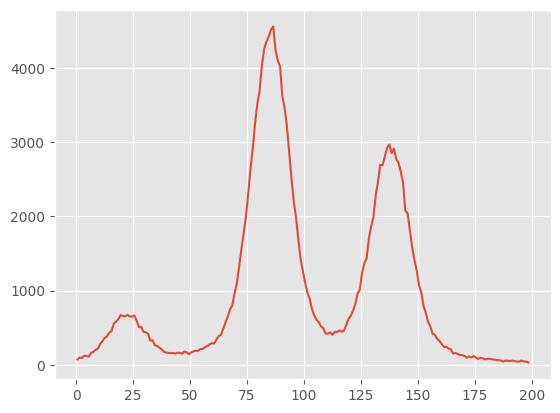

In [18]:
n_peaks = 3
n_events = 2e5
n_bins = 200

def rand_simplex(size):
    h = np.round(np.random.uniform(size=size-1), 3)
    h = np.append(h, [0, 1])
    h = np.sort(h)
    return np.diff(h) 

E0 = np.sort(np.random.uniform(10,190, size=n_peaks))  # means of the lorentzians
gamma = np.random.uniform(1, 15, size=n_peaks)         # widths of the lorenztians
heights = rand_simplex(n_peaks)                        # relative heights of the peaks, their sum must be 1
spread = np.random.uniform(1,10)                       # experimental resolution's spread

events = np.array([])
for i in range(n_peaks):
    events = np.append(events, stats.cauchy.rvs(loc=E0[i], 
                                                scale=gamma[i]/2, 
                                                size=int(heights[i]*n_events)))  # generate the events
n_events = len(events)                                                           # correct discrepancies from rounding
events = events + np.random.normal(scale = spread, size=n_events)                # add gaussian spread                                    

true_pars = list(it.chain.from_iterable([E0, gamma, heights, [spread]]))
counts, edges = np.histogram(events, bins=np.arange(0,n_bins,1))
centers = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
plt.plot(centers, counts)

### Assemble the data.
The model fits the binned data and requires the number of bins of the gaussian window that will be convolved with the true response to be specified. Due to the implementation of the discrete convolution, this value $N\_window$ must be odd, otherwise the results will be shifted by 1 bin. The variables starting with $p\_$ are the prior's parameters and can be set with a rough guess from the previous graph.

In [62]:
N_window = 51
p_x0 = [20, 80, 130]
p_g = [10, 10 , 10]
p_h = [0.1, 0.5, 0.4]
p_sigma = 5

data={"N": len(counts), 
      "N_window": N_window,
      'N_peaks': n_peaks,
      'counts': counts.tolist(), 
      'x': centers.tolist(), 
      'p_sigma': p_sigma, 
      'p_g': p_g, 
      'p_x0': p_x0,
      'p_h': p_h,
      'prior': 1}

### Sample from the priors
Plot a prior predictive check and the sampled prior distributions

15:43:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:43:16 - cmdstanpy - INFO - CmdStan done processing.


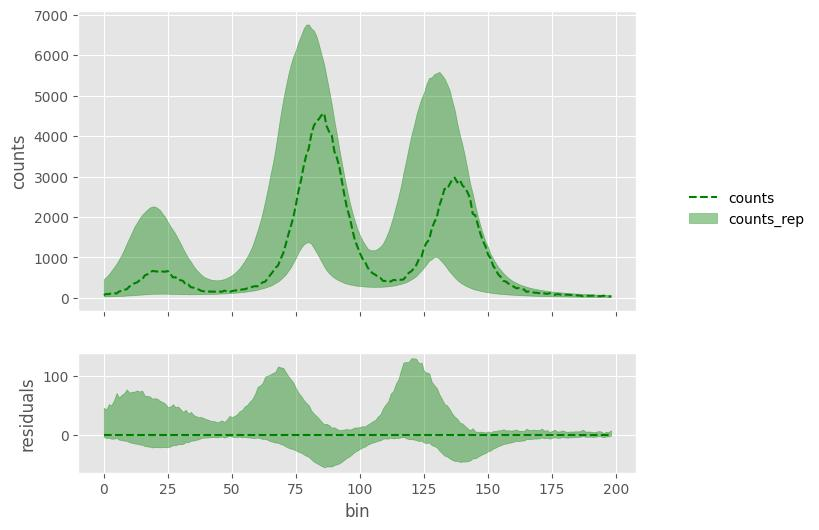

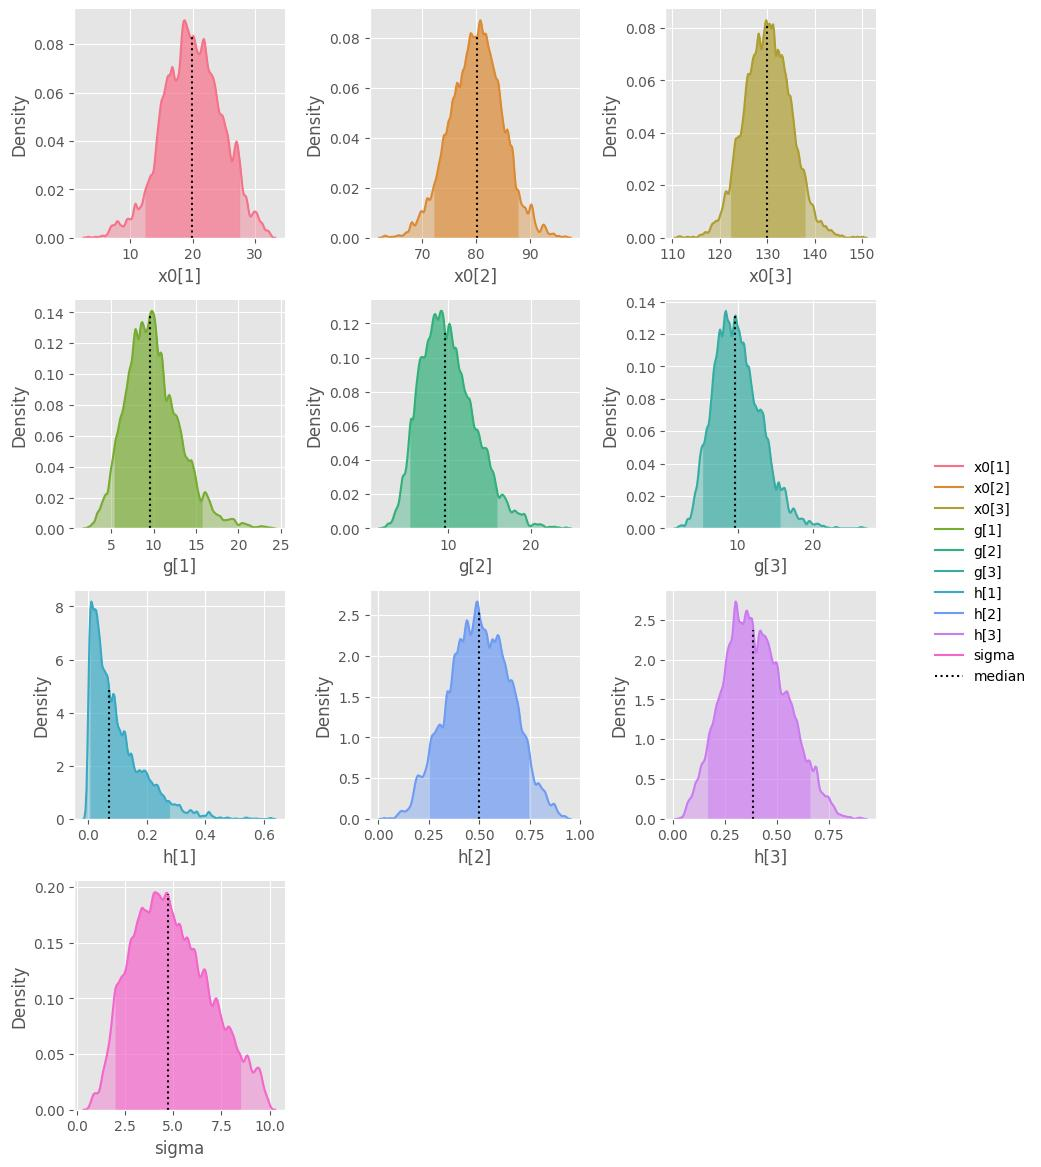

In [49]:
prior_fit = model.sample(data,
                         chains=4,
                         iter_warmup=100,
                         iter_sampling=1000)

plotter = FitPlotter(prior_fit, fit_title='prior_fit')
plotter.predictive_check('counts_rep', 
                         data=data, 
                         data_key='counts')
plotter.kde_plot(hue='variable')

### Prepare the initializations of each chain
Since this fit is quite complex, sampling with the default initial points will converge really slowly or not at all. Suitable starting values for each chain can be drawn from the prevously sampled priors by using $inits\_from\_priors$. This function creates a .json file containing the inits for each chain and returns the filenames.

In [37]:
n_chains = 4
init_files = inits_from_priors(model, prior_fit, n_chains)
print(init_files)

['inits/init0.json', 'inits/init1.json', 'inits/init2.json', 'inits/init3.json']


### Sample from the model
This usually requires some minutes. Due to the convolution, the performance mainly depends from the number of bins used for the gaussian window and the data. When sampling from unbounded distributions with fast-increasing variance, such as the Gamma distribution used as a prior for $g$ and $sigma$, some draws may have very big values and be considered as inf, resulting in an exception. This is usually not a problem if it doesn't happen too frequently.

In [ ]:
data['prior'] = 0
fit = model.sample(data,
                   chains=4,
                   iter_warmup=300,
                   iter_sampling=1000,
                   save_warmup=True,
                   inits=init_files)

Confirm the convergence by checking the HMC diagnostics and print a summary for all parameters

In [39]:
print(fit.diagnose())

Processing csv files: /tmp/tmpr1s92s2m/convolved_lorentziansj7m2gjxu/convolved_lorentzians-20230428153412_1.csvWarning: non-fatal error reading adaptation data
, /tmp/tmpr1s92s2m/convolved_lorentziansj7m2gjxu/convolved_lorentzians-20230428153412_2.csvWarning: non-fatal error reading adaptation data
, /tmp/tmpr1s92s2m/convolved_lorentziansj7m2gjxu/convolved_lorentzians-20230428153412_3.csvWarning: non-fatal error reading adaptation data
, /tmp/tmpr1s92s2m/convolved_lorentziansj7m2gjxu/convolved_lorentzians-20230428153412_4.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [40]:
pars = plotter.validate_parameters('all_stan')
fit.summary().loc[pars]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
x0[1],22.128800,0.001820,0.094391,21.972500,22.128100,22.287100,2689.060000,7.493990,0.999703
x0[2],85.325100,0.000539,0.033933,85.270500,85.324900,85.380700,3962.510000,11.042900,0.999556
x0[3],137.851000,0.000723,0.042877,137.780000,137.851000,137.921000,3520.880000,9.812130,1.000130
g[1],7.040650,0.005821,0.270580,6.608030,7.042180,7.488600,2160.350000,6.020560,1.003760
g[2],7.847490,0.002683,0.115539,7.660460,7.844390,8.041240,1854.140000,5.167200,1.000950
g[3],8.337090,0.002595,0.118201,8.141280,8.338150,8.528370,2074.860000,5.782300,0.999539
h[1],0.075139,0.000017,0.000810,0.073833,0.075148,0.076510,2369.950000,6.604670,1.003210
h[2],0.553480,0.000027,0.001471,0.551117,0.553465,0.555910,3077.330000,8.576050,1.000170
h[3],0.371381,0.000022,0.001322,0.369259,0.371380,0.373574,3730.070000,10.395100,0.999545
sigma,6.506102,0.001300,0.051853,6.421060,6.505840,6.592420,1591.456491,4.435139,0.999822


Plot the convergence of each parameter, the posterior predictive check and the posterior distributions. As can be seen, all the posteriors converge to the true values

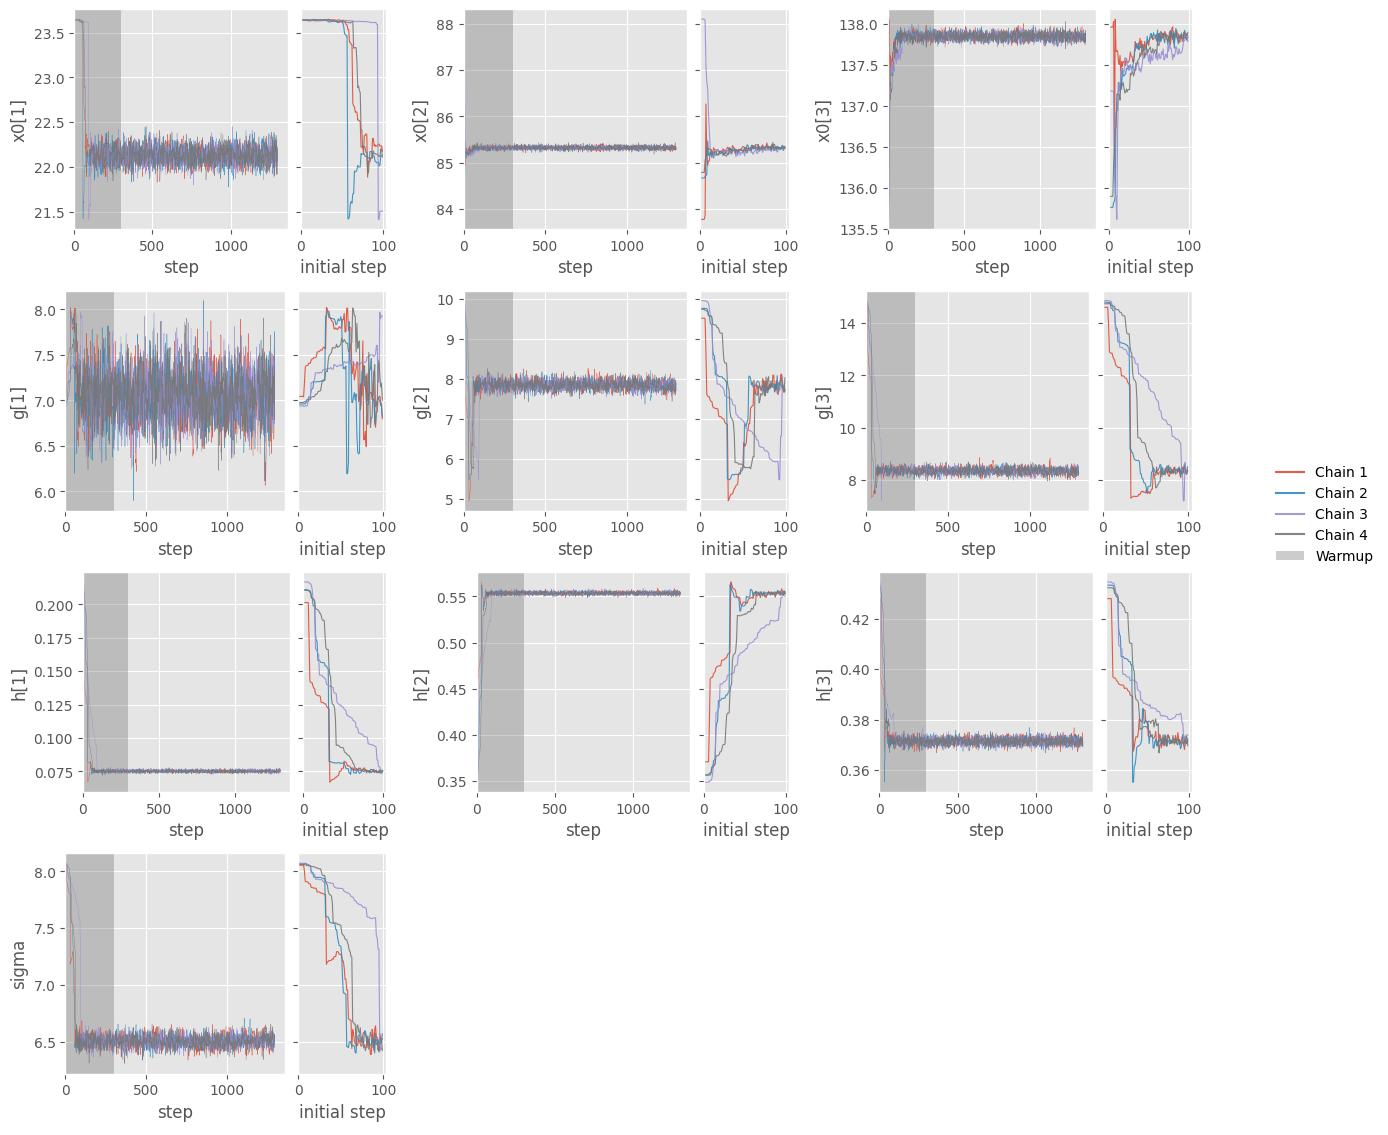

In [50]:
plotter.add_fit(fit, fit_title='lorentzian_fit')
plotter.convergence_plot(initial_steps=100)

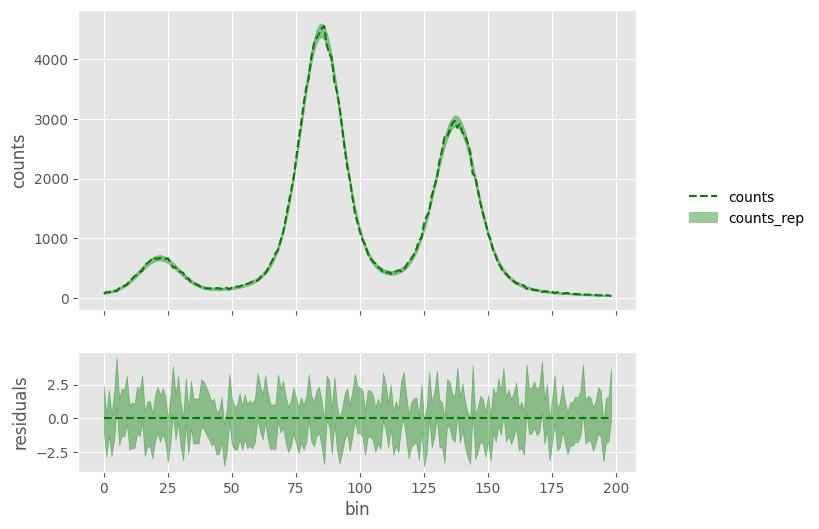

In [51]:
plotter.predictive_check('counts_rep', 
                         data=data, 
                         data_key='counts')

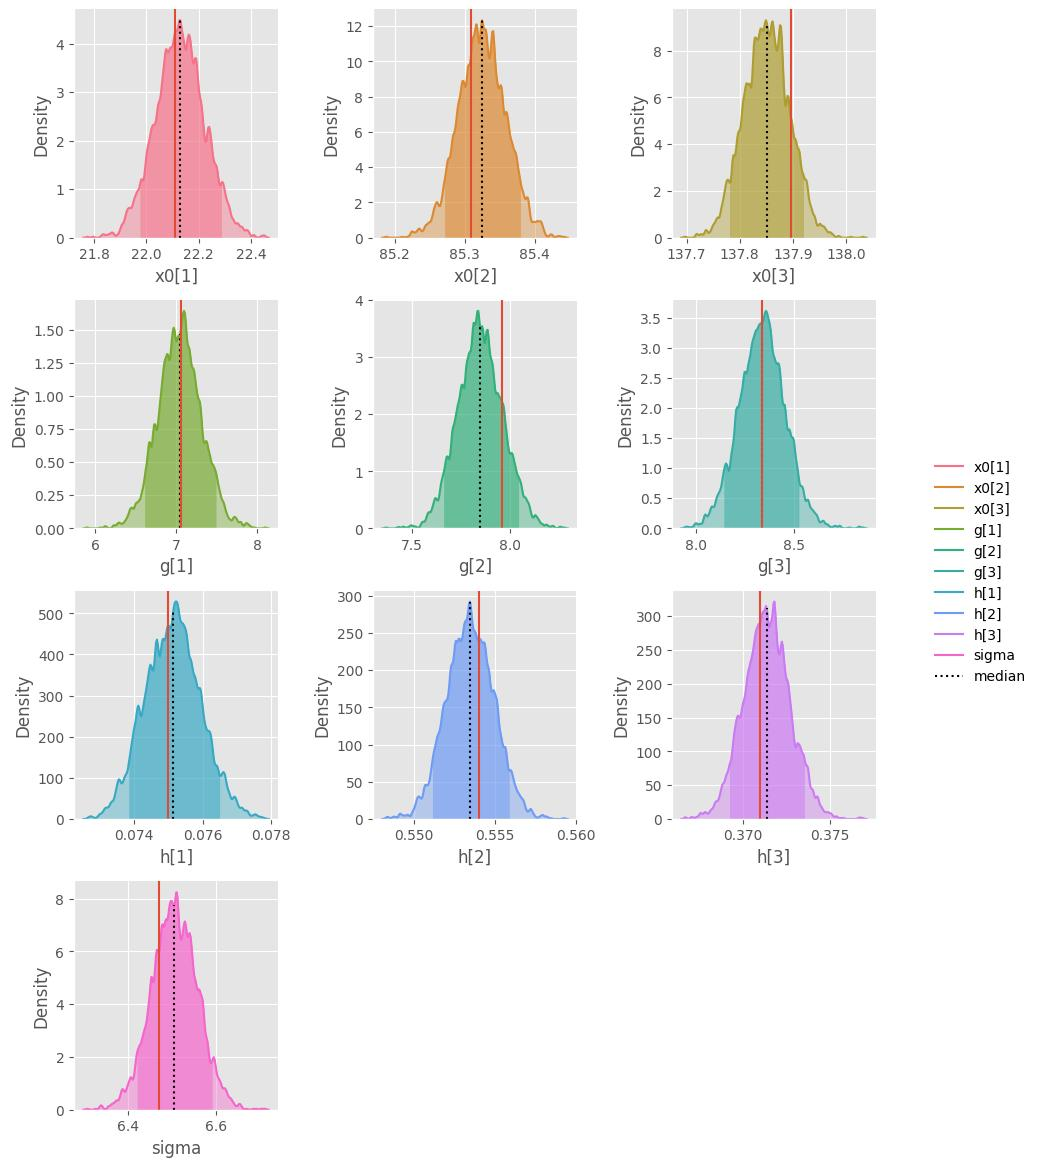

In [54]:
plotter.kde_plot(hue='variable')
plt.close()
plotter.add_lines(true_pars)
plotter.get_current_figure()

For models with many variables, $pair\_grid$ allows to inspect the correlations between them. In this case correlations are stronger between $g_i$ and $sigma$, since they both contribute to the total width of the peaks, and between the relative heights, since they are a unit vector.

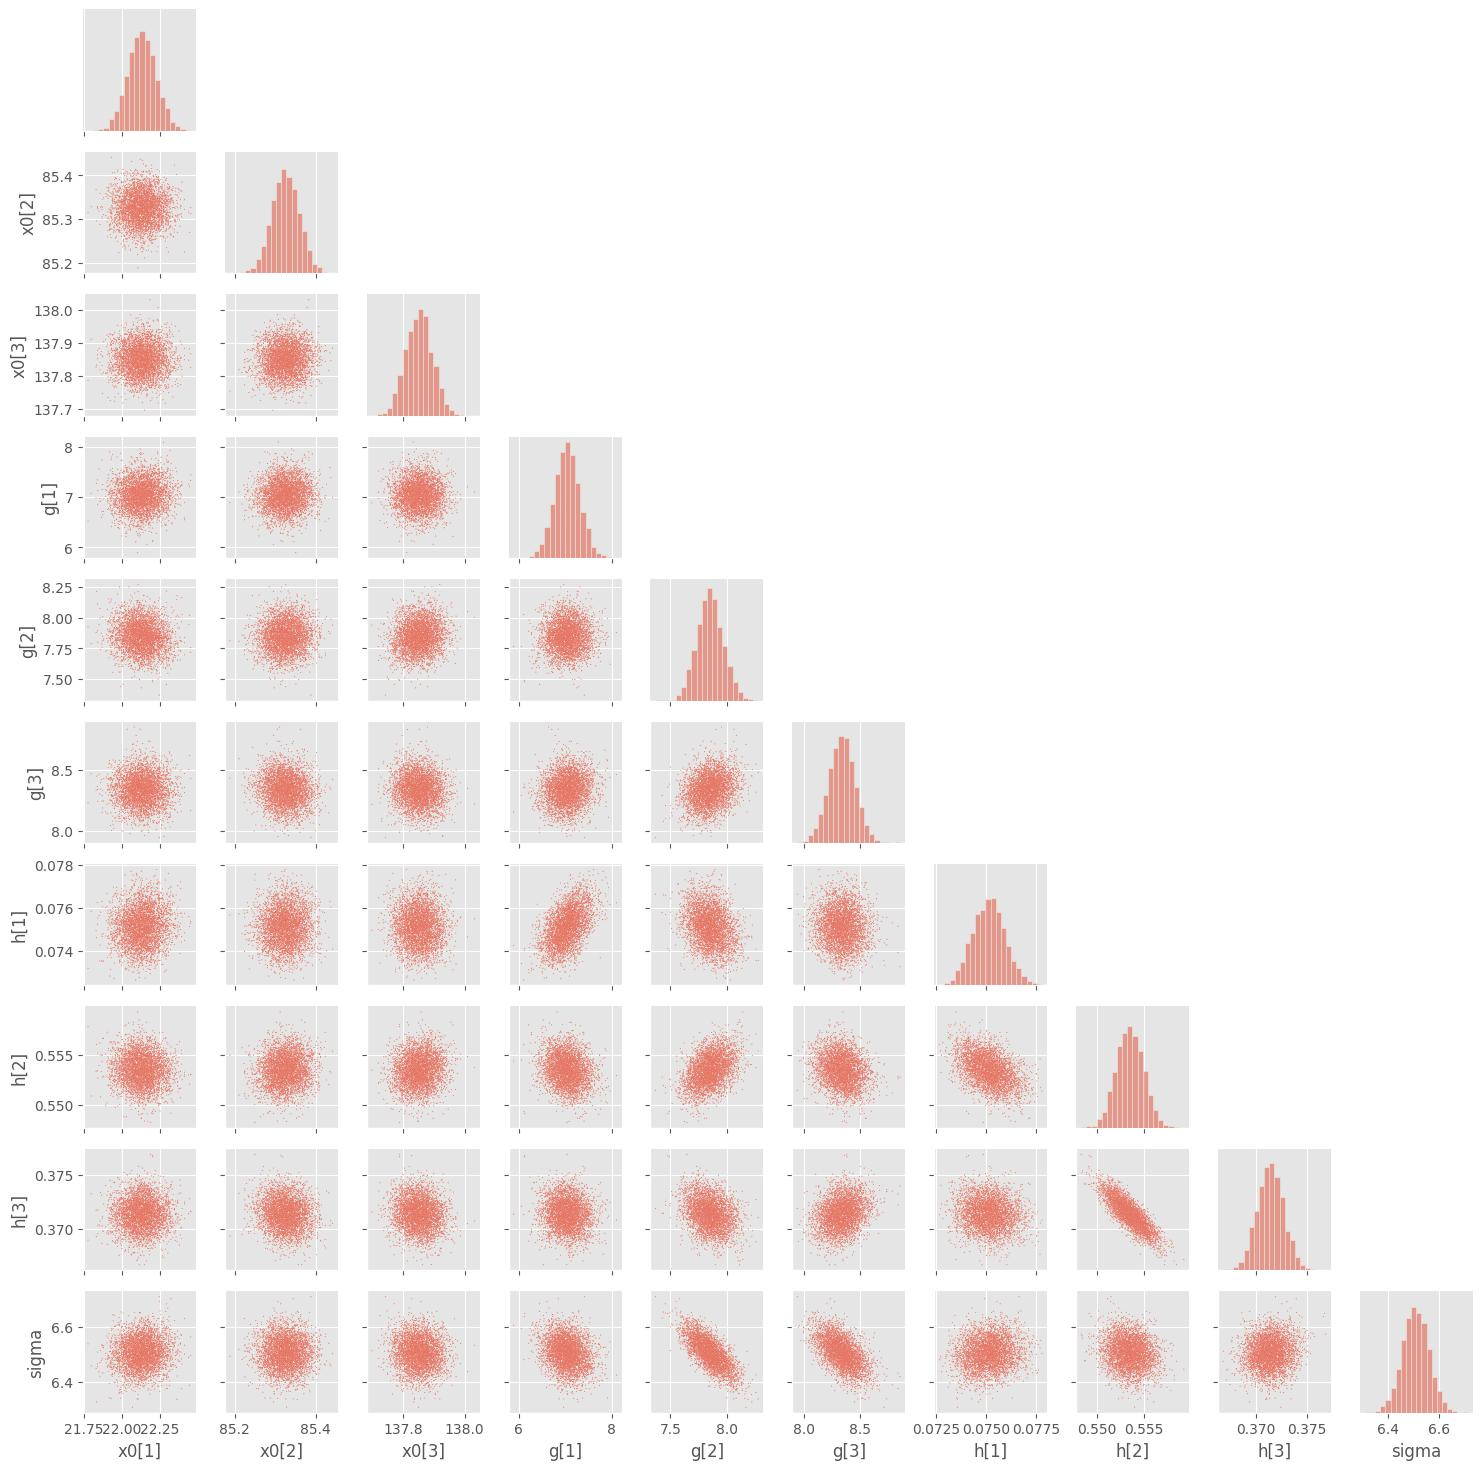

In [60]:
plotter.pair_grid()

This function also supports plotting multiple fits.

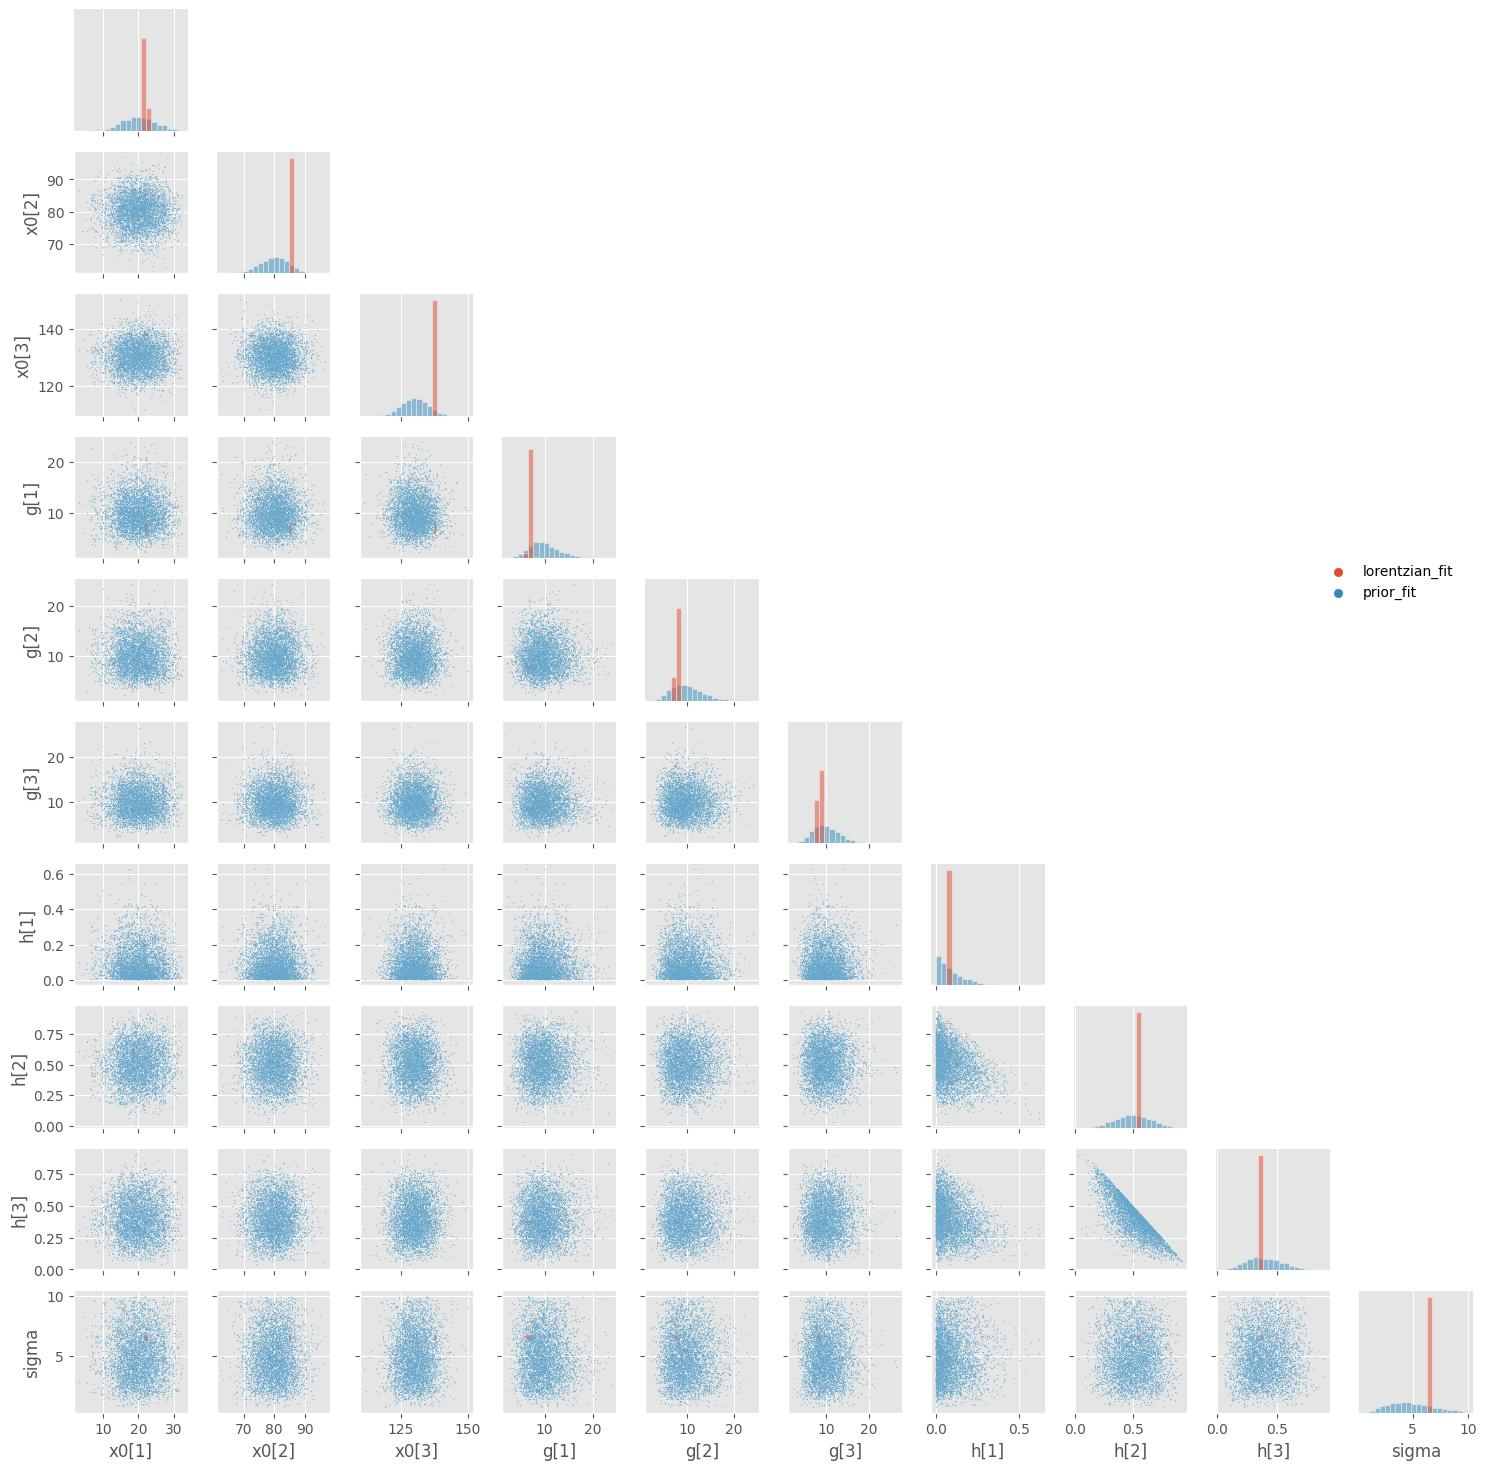

In [61]:
plotter.pair_grid(fit_titles='all', legend=True)